In [1]:
from torch.quasirandom import SobolEngine
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
import hydra
import torch
import botorch
import wandb
from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from mgp_models.fit_fully_bayesian import fit_fully_bayesian_mgp_model_nuts, fit_partially_bayesian_mgp_model
from mgp_models.utils import *
from mgp_models.acquisition import *
from mgp_models.test_functions import *
import time

c:\Users\felip\anaconda3\envs\bo-cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor
import torch

from botorch.acquisition import AnalyticAcquisitionFunction
from mgp_models.fully_bayesian import  MGPFullyBayesianSingleTaskGP
from botorch.posteriors.fully_bayesian import GaussianMixturePosterior, MCMC_DIM


In [3]:
tkwargs = {
"device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
"dtype": torch.double,
}

In [4]:
class SALHellingerMMAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:


        posterior = self.model.posterior(X, ll= self.ll)
        n_models = posterior._mean.shape[MCMC_DIM]
        mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
        BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
        var = posterior._variance.sum(dim=MCMC_DIM)
        mixture_variance = BQBC + var
        sigma_1 = mixture_variance.repeat(n_models,1,1)
        mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
        mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
        sigma_2 = posterior.variance
        mu_2 = posterior.mean
        up = 2*torch.sqrt(sigma_1)*torch.sqrt(sigma_2)
        down = sigma_1+sigma_2
        to_sqrt = up.div(down)
        sqrted = torch.sqrt(to_sqrt)
        mean_up = mu_1 - mu_2
        mean_up = mean_up.pow(2)
        exped = torch.exp(-0.25*mean_up.div(down))
        right = sqrted* exped
        hellinger = 1 - right
        return hellinger.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        



In [5]:
class SALWassersteinMMAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:


        posterior = self.model.posterior(X, ll= self.ll)
        n_models = posterior._mean.shape[MCMC_DIM]
        mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
        BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
        var = posterior._variance.sum(dim=MCMC_DIM)
        mixture_variance = BQBC + var
        sigma_1 = mixture_variance.repeat(n_models,1,1)
        mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
        mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
        sigma_2 = posterior.variance
        mu_2 = posterior.mean
        diff_means = mu_1-mu_2
        diff_stds = torch.sqrt(sigma_2) - torch.sqrt(sigma_1)
        wasserstein = torch.sqrt(diff_means.pow(2)+diff_stds.pow(2))
        return wasserstein.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)
        

In [6]:
class BALDKLMMAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: MGPFullyBayesianSingleTaskGP,
        maximize: bool = True,
        ll: Optional[Tensor] = None
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.ll = ll

    def forward(self, X: Tensor) -> Tensor:


        posterior = self.model.posterior(X, ll= self.ll)
        n_models = posterior._mean.shape[MCMC_DIM]
        mean_minus_mgpmean = posterior._mean - posterior.mixture_mean.repeat(n_models,1,1)
        BQBC = mean_minus_mgpmean.pow(2).sum(dim=MCMC_DIM)
        var = posterior._variance.sum(dim=MCMC_DIM)
        mixture_variance = BQBC + var
        sigma_1 = mixture_variance.repeat(n_models,1,1)
        mixture_mean = posterior._mean.sum(dim=MCMC_DIM)
        mu_1 = posterior.mixture_mean.repeat(n_models,1,1) #mixture_mean.repeat(n_models,1,1)
        sigma_2 = posterior.variance
        mu_2 = posterior.mean
        left = torch.log(torch.sqrt(sigma_2).div(torch.sqrt(sigma_1)))
        dif_means = mu_1-mu_2
        up = sigma_1 + dif_means.pow(2)
        KL = left + up.div(2*sigma_2) - 0.5
        return KL.mul(posterior.shaped_weights).sum(dim=MCMC_DIM)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_yhat(gp, test_X, tkwargs, batch_size = 100):

    total_batches = test_X.size(0) // batch_size
    Y_full = torch.Tensor().to(**tkwargs)
    for i in range(total_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_X = test_X[start_idx:end_idx]
        posterior = gp.posterior(batch_X)
        Y_hat = posterior.mean
        Y_full = torch.cat((Y_full, Y_hat),1)
    return Y_full

def plot_gps(test_X, std, synthetic_function, Y_hat, X_train, Y_train, weights = None):

        # Define the sine function
    test_X = convert_bounds(test_X,BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    #y = test_Y.detach().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train,BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()

    # Generate noisy versions of y
    gps_y = Y_hat.detach().squeeze().numpy()
    
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y})
    df['y_lower'] = df.y - ci
    df['y_upper'] = df.y + ci

    gp_cols = []
    for i in range(len(gps_y)):
        gp_col = 'gp_' + str(i)
        df[gp_col] = gps_y[i]
        gp_cols.append(gp_col)
    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)
    
    # Normalize the ll values to 0-1 for color mapping
    if weights is not None:
        #ll = ll.detach().numpy()
        norm = plt.Normalize(min(weights), max(weights))
        cmap = plt.cm.viridis  # Choose a colormap

    plt.figure(figsize=(10, 6))
    plt.plot(df.x, df.y, label='true function', color='red')
    plt.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')

    for i, gp_col in enumerate(gp_cols):
        if weights[i] >0:
            color = cmap(norm(weights[i])) if weights is not None else 'blue'  # Use ll value for color if ll is provided
            plt.plot(df.x, df[gp_col], color=color)
    
    plt.scatter(x_points, y_points, color='gold', s=200, marker='*', label='queried points', zorder=30)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Sine Function with Various Levels of Noise and 96% CI for the Original')
    plt.show()


In [8]:
DIM = 1
BOUNDS =  [[0, 20]]
type = 'part_bayesian'

dict params
None
{'outputscale': tensor([3.4392], dtype=torch.float64), 'mean': tensor([-1.2251], dtype=torch.float64), 'noise': tensor([1.0732], dtype=torch.float64), 'lengthscale': tensor([[0.3116]], dtype=torch.float64)}
32
{'noise': tensor([1.0732, 0.5565, 0.9433, 3.7246, 1.2551, 3.7455, 1.0200, 0.9050, 0.4930,
        3.3743, 1.2357, 1.9801, 0.5247, 0.2972, 5.8165, 0.5059, 0.4160, 0.3097,
        0.7437, 0.7533, 0.6204, 0.4968, 0.2247, 0.2849, 2.7919, 2.2044, 8.3494,
        3.4648, 0.3068, 1.4492, 3.3906, 1.0951], dtype=torch.float64), 'outputscale': tensor([3.4392, 0.9098, 0.8250, 0.4213, 0.1003, 2.2049, 0.8459, 0.5216, 0.6971,
        0.9637, 0.2846, 0.4367, 0.5992, 0.5224, 0.7183, 4.3656, 7.1980, 1.4132,
        0.9027, 1.4915, 1.0125, 1.8969, 0.3811, 1.3628, 1.5149, 1.1035, 0.1951,
        0.7706, 1.2293, 1.0739, 0.8244, 0.7120], dtype=torch.float64), 'mean': tensor([-1.2251, -0.1607,  0.7398, -0.8479, -0.1101, -0.3247, -0.6863,  0.2220,
         1.4062,  1.7751, -0.1508,  0.

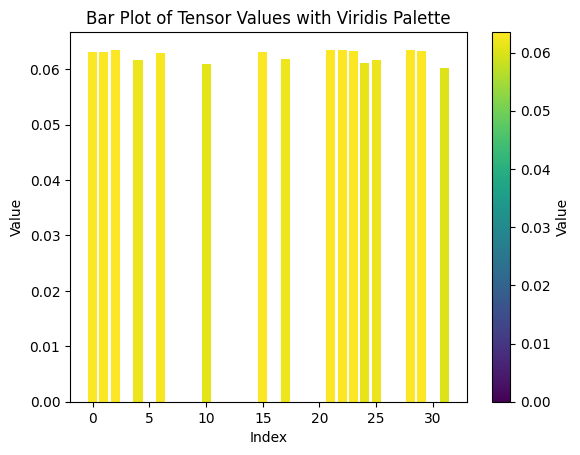

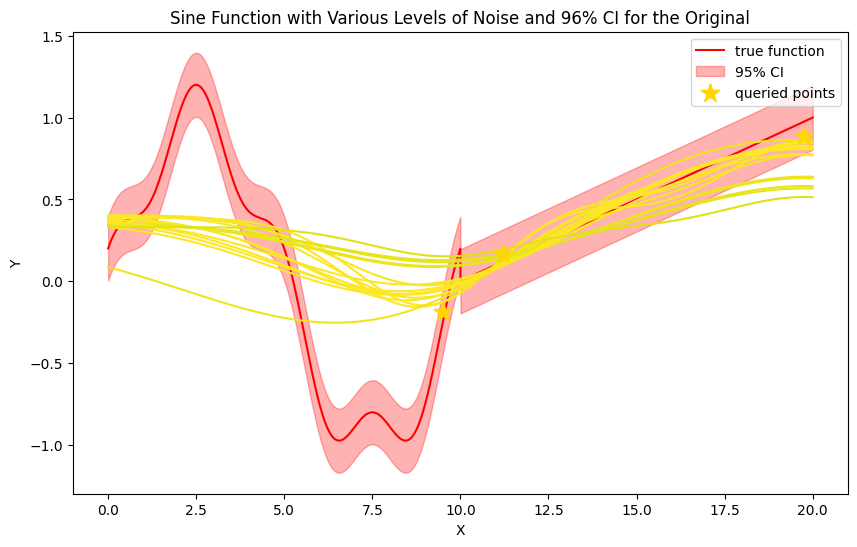

tensor([[0.9875]], dtype=torch.float64)
dict params
{'noise': tensor([0.1301], dtype=torch.float64), 'lengthscale': tensor([[0.2032]], dtype=torch.float64), 'outputscale': tensor([0.6612], dtype=torch.float64), 'mean': tensor([0.2040], dtype=torch.float64)}
32
{'noise': tensor([1.3488, 0.3790, 0.4597, 0.5636, 3.7304, 1.8006, 4.1635, 1.8773, 0.1960,
        2.5222, 5.6211, 1.5180, 0.5254, 0.1246, 0.0695, 1.9865, 1.0064, 0.4805,
        0.2742, 0.5544, 0.7063, 0.3699, 1.7167, 1.0758, 3.3972, 0.3287, 1.6914,
        0.3349, 2.9406, 3.9022, 0.3956, 0.1301], dtype=torch.float64), 'outputscale': tensor([2.0937, 0.5864, 4.3708, 4.1365, 0.7598, 8.4294, 0.9087, 1.7175, 1.3102,
        0.7722, 0.4392, 1.0023, 0.4298, 1.0441, 2.1066, 1.7319, 0.7287, 1.0294,
        1.1832, 1.7601, 0.5301, 0.7004, 3.1929, 1.0048, 2.2478, 0.3349, 1.0282,
        0.5776, 1.1805, 1.1836, 0.8014, 0.6612], dtype=torch.float64), 'mean': tensor([-2.7910,  2.3429,  1.0547, -0.4631,  1.0233, -1.2573,  1.6804, -0.5073,
    

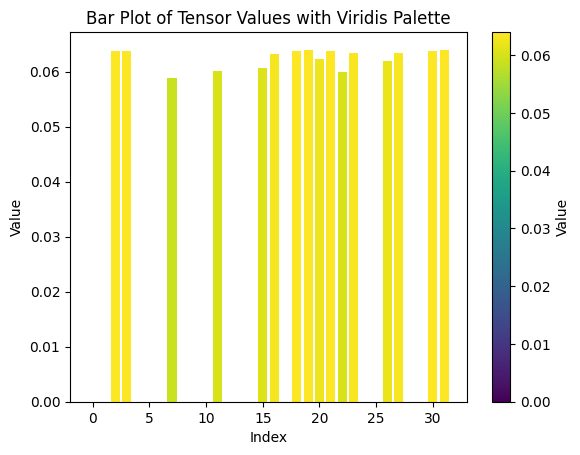

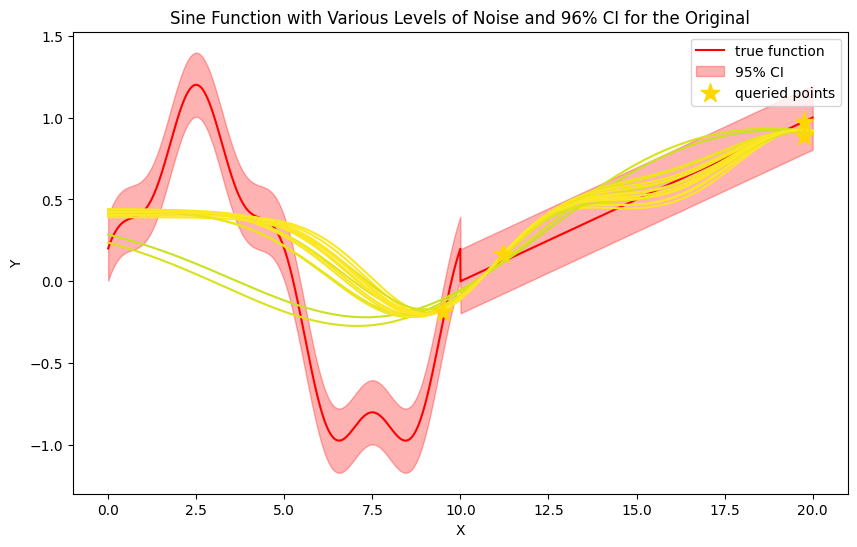

tensor([[0.9876]], dtype=torch.float64)
dict params
{'noise': tensor([0.0122], dtype=torch.float64), 'lengthscale': tensor([[0.1048]], dtype=torch.float64), 'outputscale': tensor([0.7067], dtype=torch.float64), 'mean': tensor([-0.0641], dtype=torch.float64)}
32
{'noise': tensor([0.6220, 0.1599, 0.3109, 5.0404, 0.5832, 0.6520, 0.6227, 0.9326, 2.0751,
        2.1888, 0.2129, 1.7142, 0.4013, 0.3831, 1.4385, 2.7714, 0.2644, 2.8606,
        0.4390, 1.0270, 4.7599, 0.9631, 2.0321, 0.6899, 4.2418, 1.0088, 0.5338,
        0.3150, 0.4889, 0.7485, 0.1843, 0.0122], dtype=torch.float64), 'outputscale': tensor([ 0.8854,  0.4519,  0.7369,  0.5139,  2.5586,  0.7419,  1.7155,  1.5902,
         0.5208,  0.5972,  0.7442,  0.5384,  2.1155,  2.5721, 13.1932,  2.2314,
         4.7720,  0.0982,  0.1986,  1.4611,  1.4296,  2.2855,  5.1422,  1.0121,
         1.1330,  0.2591,  1.1890,  3.1396,  0.7516,  0.5456,  0.7974,  0.7067],
       dtype=torch.float64), 'mean': tensor([-0.7282,  1.0460,  2.1236,  0.8055, 

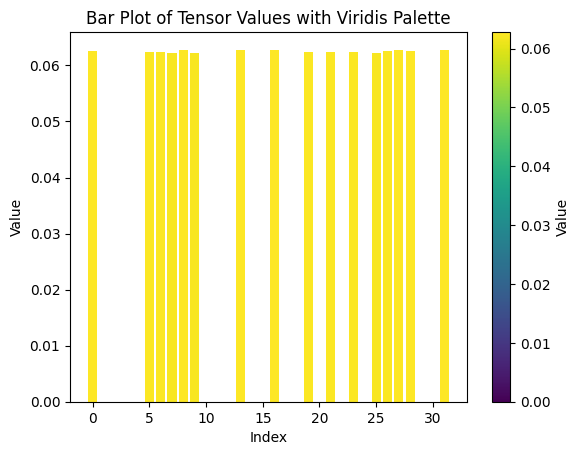

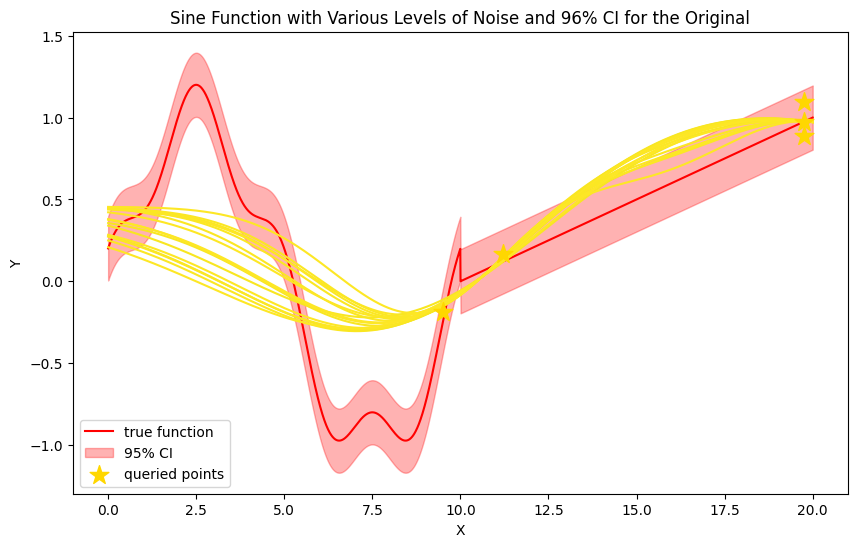

tensor([[0.4991]], dtype=torch.float64)
dict params
{'noise': tensor([0.0316], dtype=torch.float64), 'lengthscale': tensor([[0.1289]], dtype=torch.float64), 'outputscale': tensor([0.8288], dtype=torch.float64), 'mean': tensor([-0.2318], dtype=torch.float64)}
32
{'noise': tensor([0.7016, 1.0744, 0.6686, 0.6339, 0.7856, 0.6538, 4.4661, 0.7827, 0.7144,
        0.8051, 3.6990, 0.3689, 0.5571, 0.4539, 1.2875, 6.8775, 0.3101, 0.3473,
        1.8157, 6.7300, 0.7568, 0.2772, 3.8385, 0.1401, 0.4030, 1.0874, 0.3457,
        0.3762, 1.1051, 0.1250, 0.9266, 0.0316], dtype=torch.float64), 'outputscale': tensor([2.1985, 1.4151, 0.1807, 0.8086, 0.3931, 2.1269, 0.2845, 2.9633, 1.6300,
        0.2538, 0.9405, 0.1623, 0.8465, 0.4453, 3.0146, 0.4520, 0.4291, 2.3041,
        0.2983, 4.7790, 2.1593, 2.5708, 0.4404, 0.5075, 0.5012, 1.0506, 1.3857,
        1.0451, 4.1939, 0.5123, 0.3299, 0.8288], dtype=torch.float64), 'mean': tensor([ 0.5698, -0.2356, -1.4035,  0.8442,  1.6029,  1.7151,  0.2855,  1.2331,
   

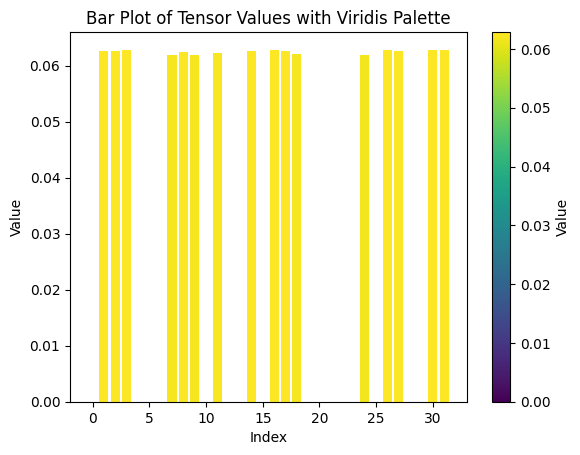

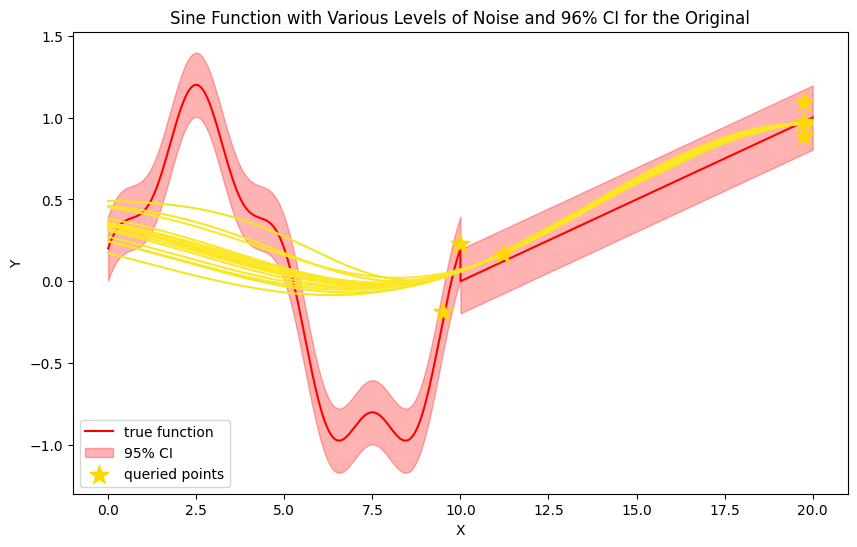

tensor([[0.4980]], dtype=torch.float64)
dict params
{'noise': tensor([0.0961], dtype=torch.float64), 'lengthscale': tensor([[0.2391]], dtype=torch.float64), 'outputscale': tensor([0.8538], dtype=torch.float64), 'mean': tensor([-0.0661], dtype=torch.float64)}
32
{'noise': tensor([ 1.2778,  4.3031,  1.2063,  0.4715,  0.3169,  0.3183,  1.7276, 12.5007,
         0.0451,  4.7643,  1.7289,  0.9606,  1.8738,  0.7647,  0.5523,  3.7788,
         2.3442,  1.5550,  0.7151,  1.1352,  0.1978,  2.9797,  1.2976,  0.9282,
         1.2617,  0.5031,  4.0623,  2.0634,  0.0917,  0.8393,  0.6557,  0.0961],
       dtype=torch.float64), 'outputscale': tensor([1.6472, 0.2913, 0.5256, 5.7053, 0.5694, 1.4849, 0.8512, 0.6157, 0.9436,
        0.1177, 2.4797, 0.5829, 4.2032, 4.5487, 0.6837, 2.0887, 3.2252, 1.2591,
        1.2620, 2.3310, 2.1858, 0.9335, 3.3325, 0.3239, 1.8414, 0.1163, 1.2091,
        0.8913, 0.5910, 1.9256, 0.1775, 0.8538], dtype=torch.float64), 'mean': tensor([-0.5511, -0.4966,  0.1150, -0.5043, 

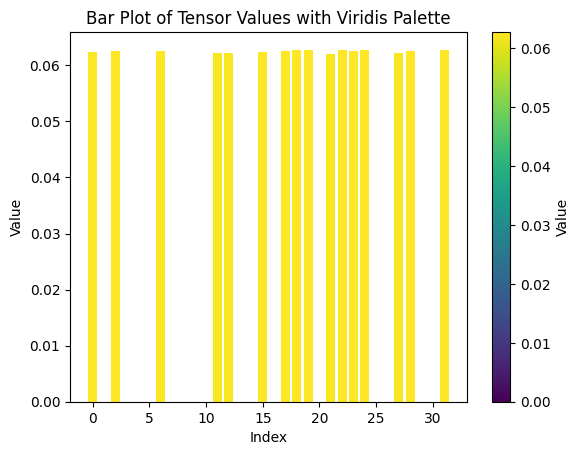

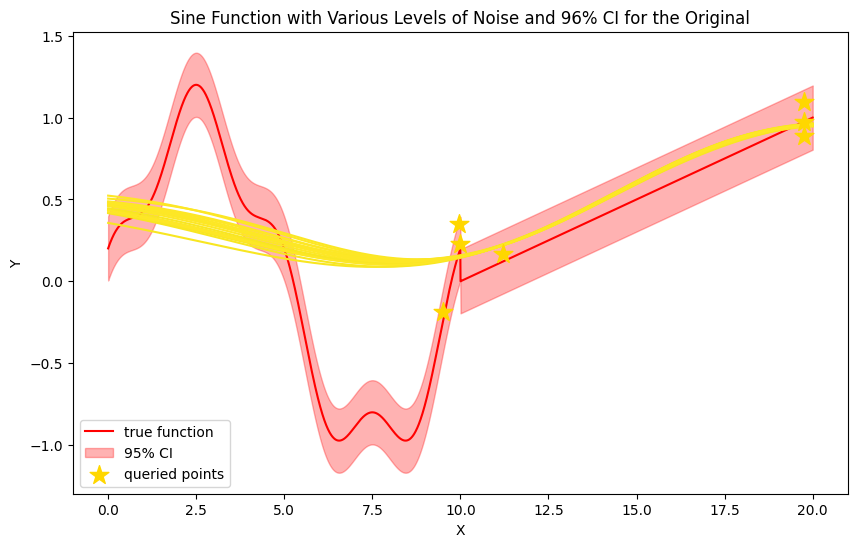

tensor([[0.9911]], dtype=torch.float64)
dict params
{'noise': tensor([0.1546], dtype=torch.float64), 'lengthscale': tensor([[0.2197]], dtype=torch.float64), 'outputscale': tensor([0.7218], dtype=torch.float64), 'mean': tensor([0.0694], dtype=torch.float64)}
32
{'noise': tensor([ 0.2876,  6.0317,  1.0021,  3.5957,  0.4286,  1.7007,  0.3082,  8.7744,
         0.4191,  0.1561,  2.7432,  1.1389,  2.8418,  0.9553,  0.2077,  1.5590,
         1.2655,  1.4856,  1.1395,  2.2654, 16.4283,  2.2361,  0.5190,  1.6691,
         1.3399,  0.8960,  2.0053,  0.4612,  0.8735,  0.0829,  0.6227,  0.1546],
       dtype=torch.float64), 'outputscale': tensor([0.7202, 1.1458, 0.2678, 1.7146, 1.4865, 1.4270, 0.2852, 0.7038, 0.3785,
        0.7440, 1.0227, 0.0321, 1.4365, 1.0205, 4.6186, 0.8008, 2.3364, 5.9577,
        1.3861, 0.6019, 0.4960, 2.1588, 1.3284, 2.5004, 0.6550, 0.3233, 0.5448,
        0.3915, 1.0430, 0.2605, 3.0674, 0.7218], dtype=torch.float64), 'mean': tensor([-4.9488e-01, -1.5470e+00,  1.1264e+00

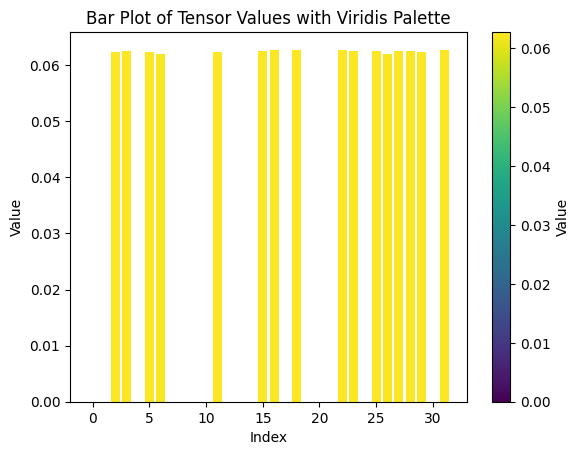

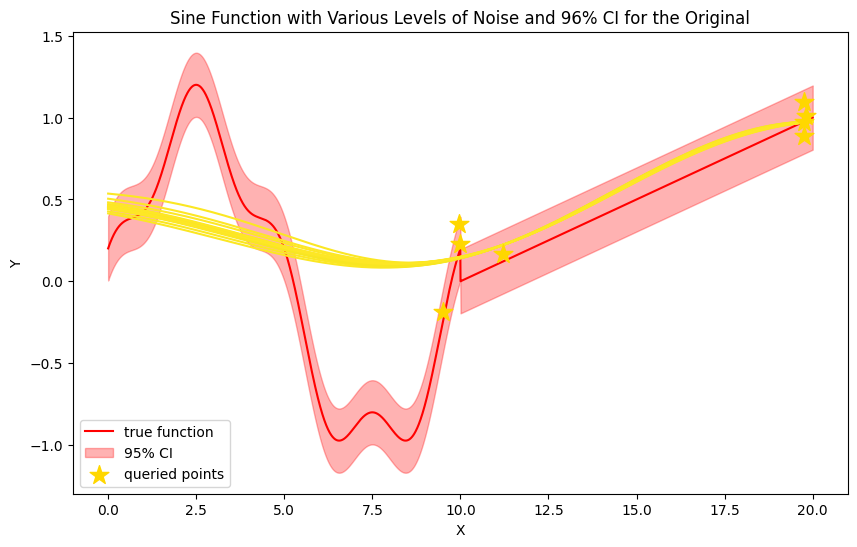

tensor([[0.4987]], dtype=torch.float64)
dict params
{'noise': tensor([0.1300], dtype=torch.float64), 'lengthscale': tensor([[0.2309]], dtype=torch.float64), 'outputscale': tensor([0.7761], dtype=torch.float64), 'mean': tensor([-0.0580], dtype=torch.float64)}
32
{'noise': tensor([0.0935, 0.8530, 0.3557, 0.3619, 0.2123, 3.5999, 1.4296, 0.4010, 0.3913,
        1.2668, 2.2608, 0.4858, 1.7524, 1.7875, 1.0895, 1.6233, 0.9468, 3.6294,
        3.3118, 3.0269, 4.0416, 2.1276, 0.3105, 1.4396, 4.1371, 4.4089, 0.4455,
        1.0421, 4.0407, 1.2219, 1.7547, 0.1300], dtype=torch.float64), 'outputscale': tensor([0.1294, 0.3811, 0.7341, 5.4985, 1.5598, 4.0093, 1.9055, 3.2184, 0.4559,
        3.3465, 2.3878, 0.0923, 1.0253, 0.3396, 7.3061, 0.4425, 0.4478, 0.4774,
        0.9469, 4.5998, 0.7977, 0.1882, 1.6324, 0.4909, 0.4372, 1.3971, 0.6317,
        0.2713, 0.9078, 1.8323, 2.5269, 0.7761], dtype=torch.float64), 'mean': tensor([-0.6653,  0.9054, -0.6119,  0.2266, -0.7255, -0.2675,  0.3345,  0.4443,
   

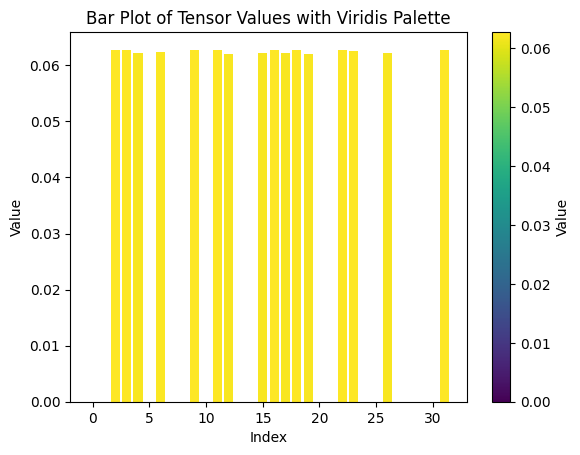

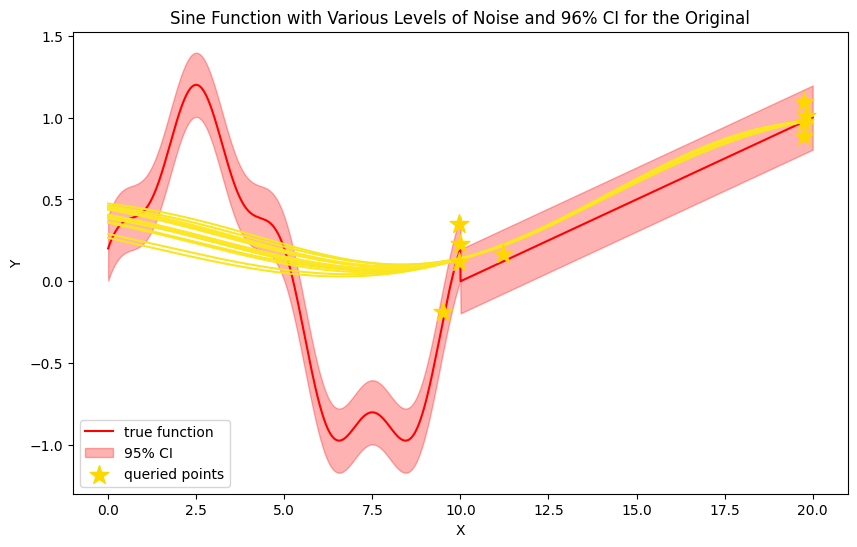

tensor([[0.9898]], dtype=torch.float64)
dict params
{'noise': tensor([0.1134], dtype=torch.float64), 'lengthscale': tensor([[0.2425]], dtype=torch.float64), 'outputscale': tensor([0.8226], dtype=torch.float64), 'mean': tensor([0.0455], dtype=torch.float64)}
32
{'noise': tensor([6.4449, 1.7614, 3.3049, 0.2397, 0.2233, 0.5096, 2.7983, 1.0670, 5.1139,
        0.9757, 0.5680, 3.4687, 0.9516, 0.4496, 0.6356, 9.4613, 5.5421, 0.1144,
        3.0390, 0.6658, 0.5289, 0.3274, 0.6068, 0.4910, 1.4397, 0.8377, 0.9510,
        2.0737, 0.0668, 4.4638, 4.1171, 0.1134], dtype=torch.float64), 'outputscale': tensor([0.2533, 2.5728, 0.3579, 0.7687, 1.6402, 0.8561, 0.9104, 1.2078, 1.7049,
        0.3397, 0.4901, 1.2584, 1.8158, 1.0581, 8.2180, 1.2797, 1.0359, 1.8928,
        2.6417, 0.9584, 0.2320, 4.3929, 0.1703, 0.3159, 0.8396, 0.9235, 4.4189,
        0.6698, 1.0769, 0.6326, 2.5841, 0.8226], dtype=torch.float64), 'mean': tensor([ 0.2502,  0.2258, -0.7400, -0.7553,  0.3796, -1.1939,  1.7403, -1.2284,
    

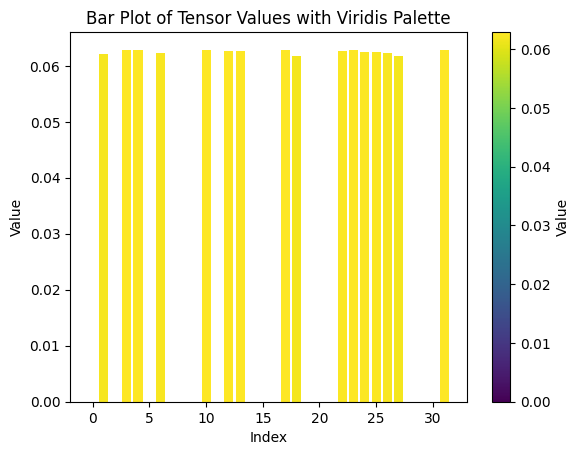

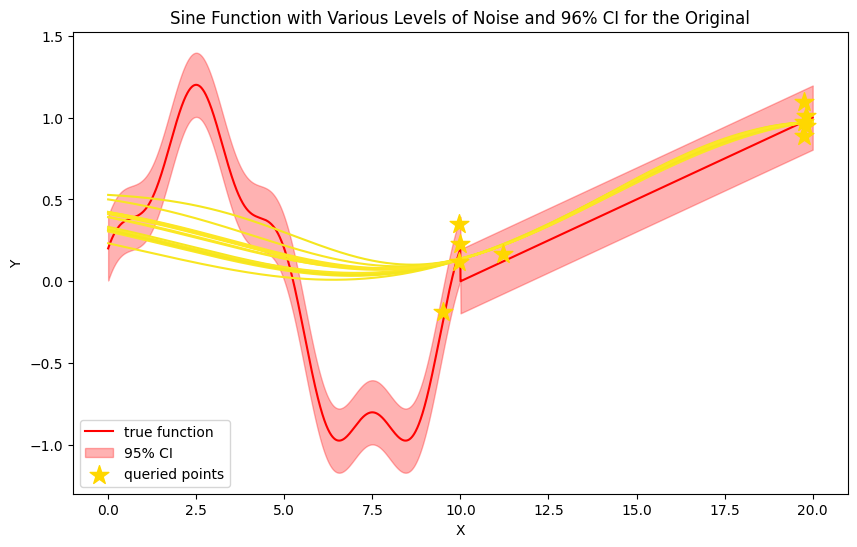

tensor([[0.9895]], dtype=torch.float64)
dict params
{'noise': tensor([0.1016], dtype=torch.float64), 'lengthscale': tensor([[0.2518]], dtype=torch.float64), 'outputscale': tensor([0.8525], dtype=torch.float64), 'mean': tensor([-0.0731], dtype=torch.float64)}
32
{'noise': tensor([ 1.0343,  0.2519, 11.4130,  0.7623,  0.4951,  1.4496,  0.9136,  0.4669,
         2.4652,  1.2170,  3.0020,  0.9493,  3.0691,  0.1345,  3.2358,  2.0095,
         0.3100,  0.7129,  8.2508,  1.5690,  0.9391,  1.6708,  0.6670,  4.2716,
         0.6773,  0.3481,  0.2227,  0.5977,  1.5205,  0.9979,  3.6548,  0.1016],
       dtype=torch.float64), 'outputscale': tensor([0.3599, 0.9161, 1.8245, 0.8426, 1.5238, 0.7886, 0.4158, 0.3928, 0.3280,
        0.9085, 0.7147, 0.5635, 0.6905, 0.1876, 0.6878, 0.3424, 0.3269, 2.1056,
        0.3432, 0.5139, 2.1970, 0.1050, 1.6893, 1.9551, 0.8598, 0.9793, 0.4510,
        1.6027, 0.5529, 0.3602, 2.5585, 0.8525], dtype=torch.float64), 'mean': tensor([-0.0625,  0.3349, -0.0371,  0.3888, 

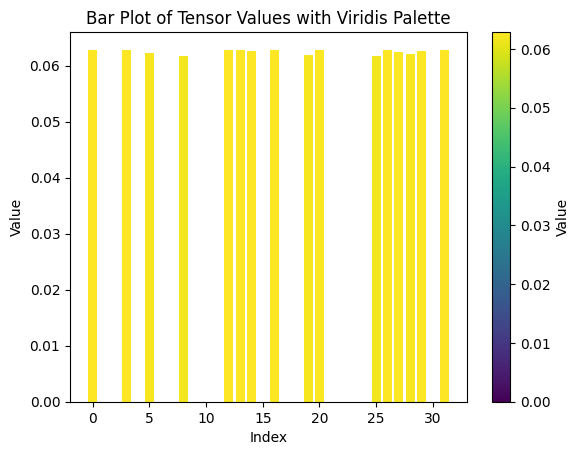

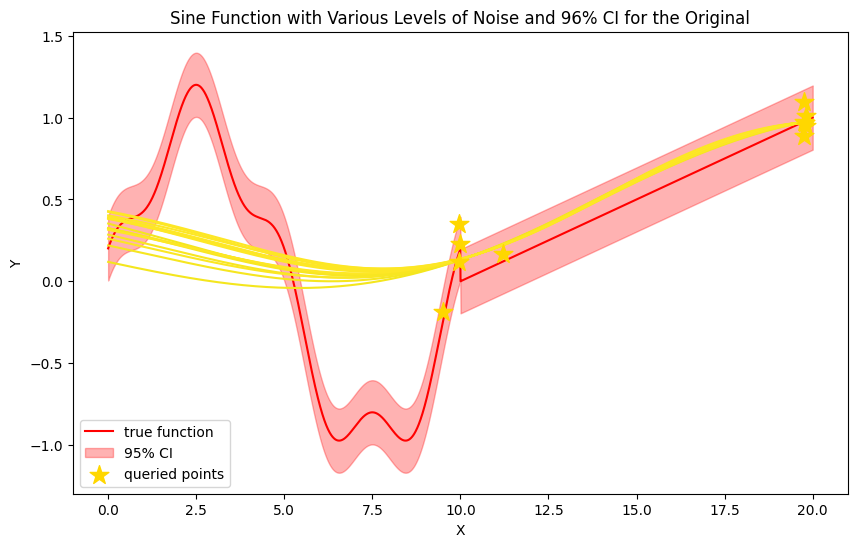

tensor([[0.4986]], dtype=torch.float64)
dict params
{'noise': tensor([0.0931], dtype=torch.float64), 'lengthscale': tensor([[0.2595]], dtype=torch.float64), 'outputscale': tensor([0.9094], dtype=torch.float64), 'mean': tensor([-0.1570], dtype=torch.float64)}
32
{'noise': tensor([0.9186, 0.7588, 2.7136, 0.3988, 0.6513, 1.3875, 0.0931, 0.3464, 2.5046,
        0.6801, 0.4492, 2.1209, 0.6683, 0.3423, 5.6055, 0.4415, 1.3575, 1.0086,
        1.4584, 0.9504, 1.4186, 2.3767, 0.8178, 1.6156, 1.9208, 2.7539, 0.3502,
        0.7188, 2.0130, 2.3032, 1.1295, 0.0931], dtype=torch.float64), 'outputscale': tensor([ 0.8361,  1.6731,  9.4004,  1.3360,  0.6795,  1.6143, 14.1346,  0.5560,
         1.0268,  0.4122,  0.4715,  0.1975,  0.8765,  1.4742,  0.7125,  0.5474,
         0.2333,  1.0603,  0.8523,  0.9066,  4.2349,  7.0973,  1.1297,  0.9869,
         0.3406,  1.2167,  0.6488,  0.2309,  0.7273,  0.1491,  3.1720,  0.9094],
       dtype=torch.float64), 'mean': tensor([ 0.9779, -0.9997,  0.8780,  1.8745, 

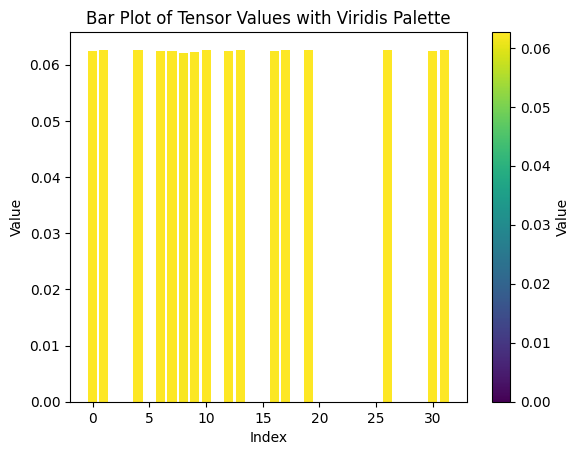

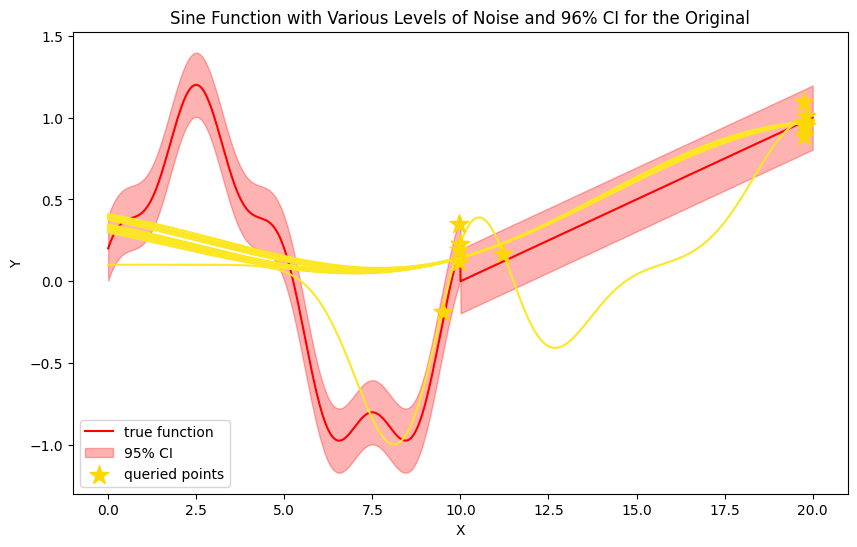

tensor([[0.8980]], dtype=torch.float64)
dict params
{'noise': tensor([0.0878], dtype=torch.float64), 'lengthscale': tensor([[0.2642]], dtype=torch.float64), 'outputscale': tensor([0.9229], dtype=torch.float64), 'mean': tensor([-0.0792], dtype=torch.float64)}
32
{'noise': tensor([ 2.9284,  1.7238,  3.9064,  0.3312,  0.1399,  0.3057,  6.6873,  0.0982,
         0.2108,  0.0754,  1.7233,  2.0374,  0.6867,  0.6822,  0.6042,  7.5708,
         3.3521,  0.1272,  0.7360,  0.7951,  1.0507,  2.1213,  1.2049,  1.8363,
         0.7750,  1.2617,  0.7693,  1.3634, 11.9588,  0.4082,  0.5018,  0.0878],
       dtype=torch.float64), 'outputscale': tensor([1.2084, 1.1973, 5.6773, 0.2123, 0.1899, 0.6550, 1.9874, 0.3711, 0.6972,
        0.9943, 4.0798, 2.9388, 0.2903, 4.4715, 0.3707, 1.1161, 0.6701, 1.1290,
        1.3512, 0.5372, 0.2095, 0.7382, 2.0777, 8.4527, 2.4864, 2.4535, 1.5683,
        6.1085, 1.4665, 0.4839, 1.4967, 0.9229], dtype=torch.float64), 'mean': tensor([ 0.5710, -0.1094,  0.2888,  0.0604, 

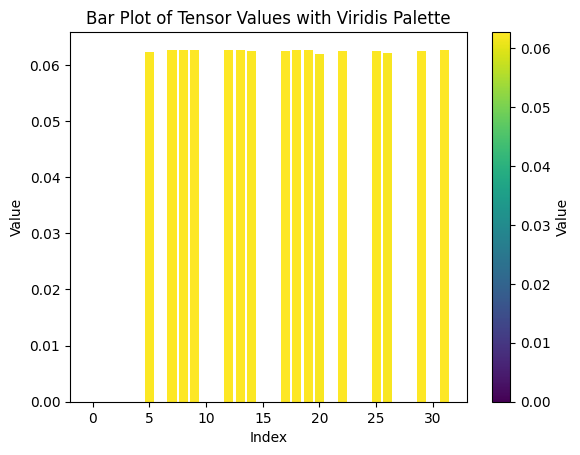

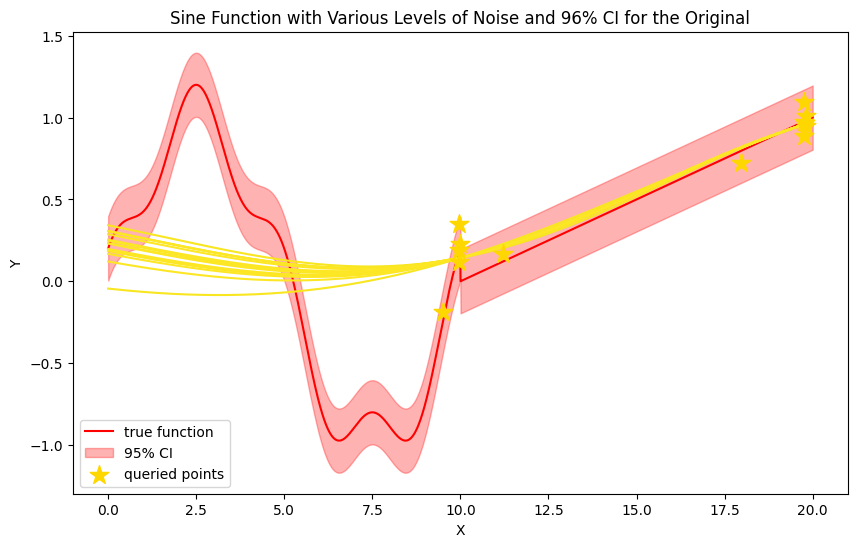

tensor([[0.4984]], dtype=torch.float64)
dict params
{'noise': tensor([0.0920], dtype=torch.float64), 'lengthscale': tensor([[0.3813]], dtype=torch.float64), 'outputscale': tensor([1.3644], dtype=torch.float64), 'mean': tensor([-0.0096], dtype=torch.float64)}
32
{'noise': tensor([0.8057, 0.6605, 1.2953, 5.3401, 1.0673, 1.9494, 0.7198, 0.2221, 0.5376,
        2.2826, 2.1726, 0.9399, 0.2786, 4.5987, 0.4019, 0.6839, 0.6686, 1.5880,
        0.8517, 0.4974, 0.5092, 0.7101, 0.4192, 0.6035, 1.3595, 2.8406, 3.8288,
        1.0503, 0.7067, 7.0513, 0.2342, 0.0920], dtype=torch.float64), 'outputscale': tensor([0.4524, 2.3759, 0.2796, 0.9208, 3.5414, 0.9953, 2.3421, 1.5570, 0.1622,
        0.2586, 1.5506, 0.6820, 1.8293, 0.5359, 3.0383, 0.8134, 5.3682, 1.6944,
        9.4268, 2.1635, 1.4628, 1.4102, 5.6504, 3.1810, 0.6051, 0.5385, 0.2302,
        1.6366, 0.9001, 0.4582, 1.6510, 1.3644], dtype=torch.float64), 'mean': tensor([-1.4536,  1.4660,  0.7551,  1.5211,  0.6955,  2.2572,  0.1725, -2.2382,
   

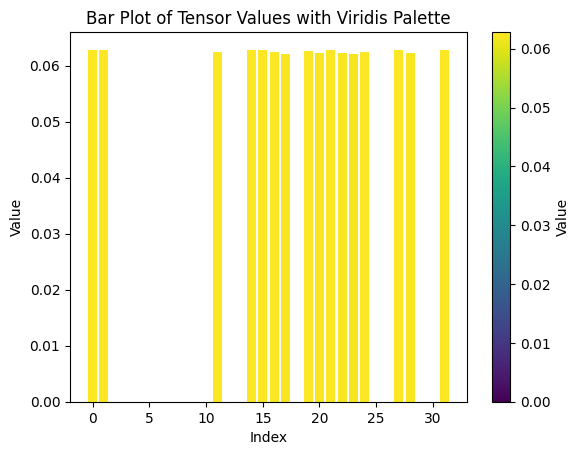

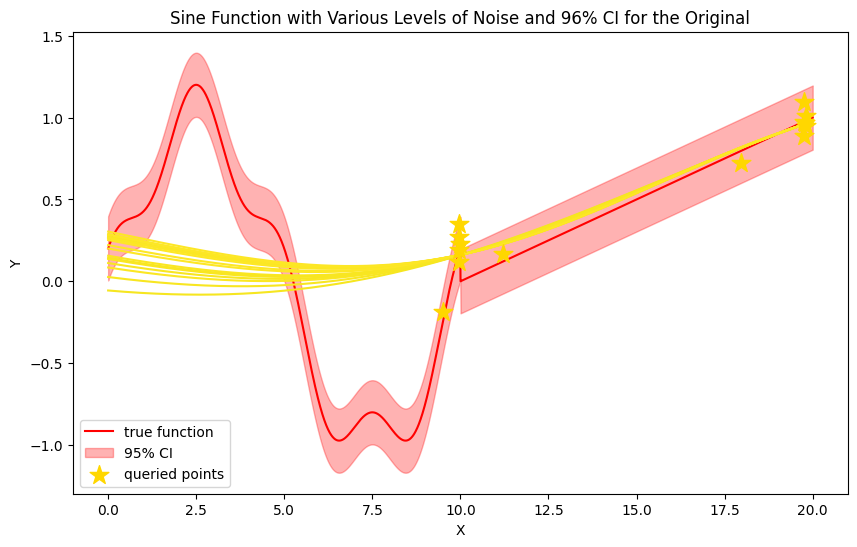

tensor([[0.9875]], dtype=torch.float64)
dict params
{'noise': tensor([0.0953], dtype=torch.float64), 'lengthscale': tensor([[0.3796]], dtype=torch.float64), 'outputscale': tensor([1.3647], dtype=torch.float64), 'mean': tensor([0.0756], dtype=torch.float64)}
32
{'noise': tensor([0.2641, 1.0027, 0.8448, 0.6031, 0.3440, 9.0882, 0.4005, 0.3078, 0.3460,
        1.2816, 0.3571, 0.2733, 1.2396, 0.7458, 1.5690, 1.6992, 4.6586, 0.5956,
        6.3826, 1.1402, 0.8213, 0.7365, 1.1845, 0.2477, 2.2478, 5.8576, 0.4652,
        2.2672, 0.2111, 1.6893, 1.2226, 0.0953], dtype=torch.float64), 'outputscale': tensor([17.7317,  1.0913,  0.2914,  0.2329,  3.1412,  0.3835,  0.3984,  0.4539,
         0.4481,  2.1405,  3.5676,  0.8098,  0.8893,  0.5534,  3.5727,  1.8385,
         0.3005,  2.7400,  1.8928,  0.5630,  2.4828,  0.2605,  1.4170,  0.7192,
         1.1759,  0.5316,  2.0775,  1.5639,  1.4176,  0.8444,  2.1708,  1.3647],
       dtype=torch.float64), 'mean': tensor([ 0.1398, -0.0100,  1.4578, -0.7132,  

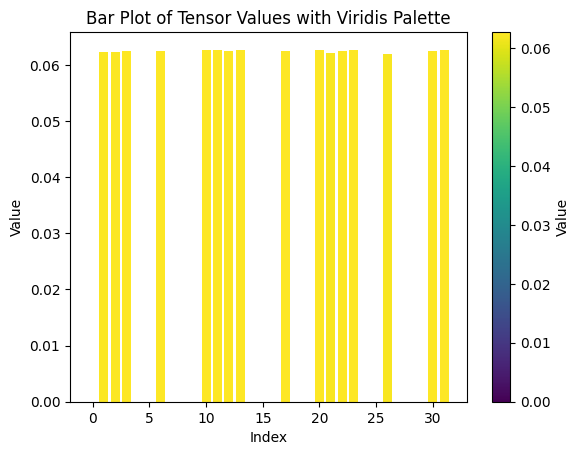

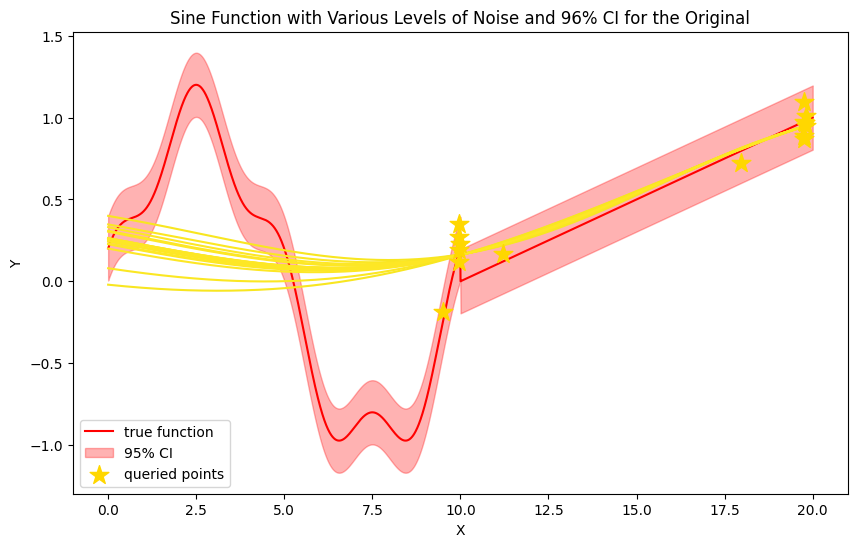

tensor([[0.4983]], dtype=torch.float64)
dict params
{'noise': tensor([0.0934], dtype=torch.float64), 'lengthscale': tensor([[0.3868]], dtype=torch.float64), 'outputscale': tensor([1.3944], dtype=torch.float64), 'mean': tensor([0.0074], dtype=torch.float64)}
32
{'noise': tensor([ 0.5349,  4.7540,  0.6017,  0.7170,  0.9290,  0.4804,  7.3470,  0.5265,
         0.4456,  1.1449,  3.4865,  1.5372,  3.3818,  1.7364,  0.2131,  0.6618,
         0.7775,  1.2587,  0.8263, 12.6610,  0.3329,  0.6598,  1.1024,  0.9926,
         2.0338,  3.7692,  1.2965,  0.2992,  0.8622,  0.5627,  0.9597,  0.0934],
       dtype=torch.float64), 'outputscale': tensor([1.9899, 0.8842, 1.4991, 0.4918, 5.5085, 0.7778, 0.7563, 0.1722, 0.4666,
        5.8241, 4.5510, 1.5996, 0.4731, 2.7812, 1.2243, 0.6703, 0.4565, 1.8848,
        0.7786, 1.2318, 1.2504, 0.9123, 1.7586, 0.5218, 0.9325, 2.8216, 0.1946,
        0.8979, 0.1146, 2.7857, 0.2438, 1.3944], dtype=torch.float64), 'mean': tensor([ 2.6891e-01, -9.0549e-01, -1.9009e-01

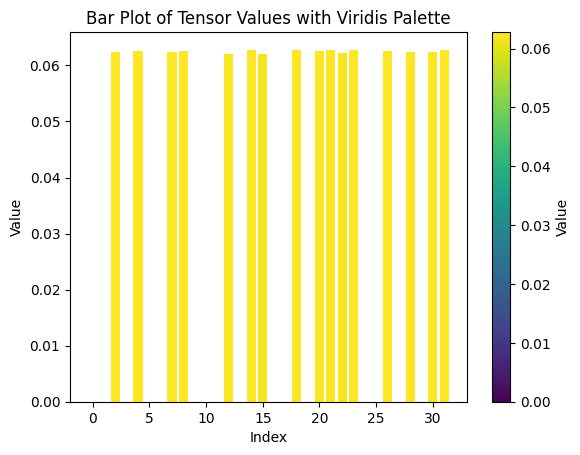

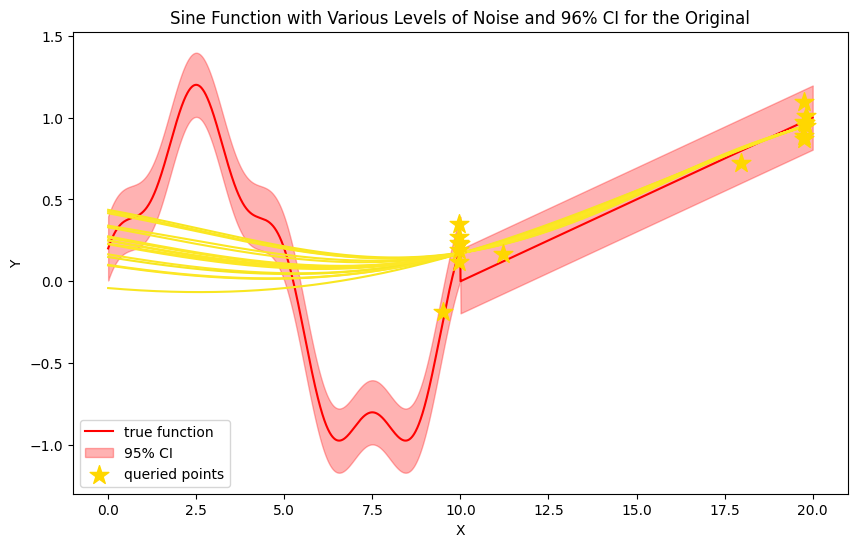

tensor([[0.4989]], dtype=torch.float64)
dict params
{'noise': tensor([0.0913], dtype=torch.float64), 'lengthscale': tensor([[0.3874]], dtype=torch.float64), 'outputscale': tensor([1.4105], dtype=torch.float64), 'mean': tensor([0.0750], dtype=torch.float64)}
32
{'noise': tensor([ 1.7679,  0.1528,  0.5410,  1.4585,  0.5896,  1.8918,  0.8578,  1.3800,
         3.5205,  4.4426,  1.3801,  1.0186, 14.3774,  0.5272,  0.0986,  0.6224,
         0.9282,  2.3516,  0.5253,  0.3179,  5.1490,  4.0996,  0.8206,  1.1780,
         3.9609,  0.3893,  1.5501,  1.1477,  0.4275,  1.7120,  5.9341,  0.0913],
       dtype=torch.float64), 'outputscale': tensor([2.6476, 0.3569, 0.3213, 0.9149, 3.2197, 0.6427, 2.3978, 1.2705, 5.3148,
        1.4720, 0.7147, 0.9843, 0.6474, 1.8888, 2.7733, 1.2118, 1.2119, 1.3373,
        5.8005, 0.3551, 0.4614, 0.4029, 2.2018, 0.8729, 2.6511, 2.9595, 1.0015,
        1.2978, 2.7654, 0.2912, 6.3425, 1.4105], dtype=torch.float64), 'mean': tensor([-1.2669,  0.6688,  0.8401, -0.7224, -

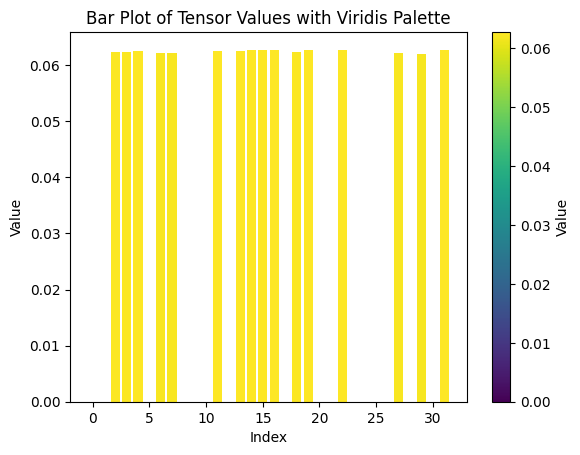

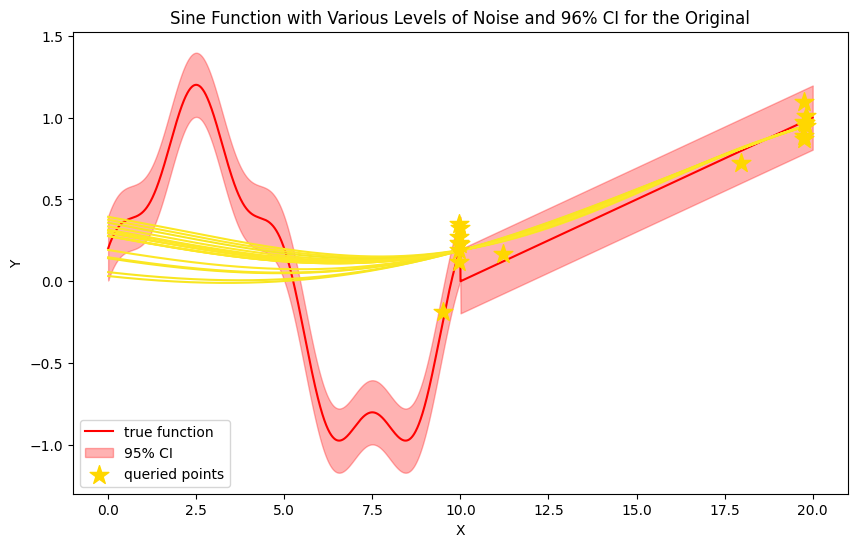

tensor([[0.9886]], dtype=torch.float64)
dict params
{'noise': tensor([0.0992], dtype=torch.float64), 'lengthscale': tensor([[0.3745]], dtype=torch.float64), 'outputscale': tensor([1.3387], dtype=torch.float64), 'mean': tensor([0.1297], dtype=torch.float64)}
32
{'noise': tensor([0.9513, 4.0279, 1.0371, 0.8601, 0.3415, 0.5331, 2.1093, 0.4333, 0.5111,
        2.0222, 0.7503, 1.4663, 0.3701, 0.7579, 0.2357, 0.2688, 1.1673, 1.1580,
        1.4073, 5.9404, 0.2581, 0.4132, 0.2050, 0.5741, 2.0899, 2.7701, 2.0531,
        0.5062, 0.0767, 2.3749, 2.1610, 0.0992], dtype=torch.float64), 'outputscale': tensor([ 0.8158,  2.1253,  1.4121,  0.3349,  1.5667,  3.0505,  3.4352,  0.3916,
         1.3471,  0.6863,  0.1575,  0.4953,  1.0608,  1.1544,  0.5841,  1.8669,
         0.2244,  0.5360,  0.7348,  4.6208,  2.7829,  0.2423,  3.9259,  0.1702,
        10.8493,  3.8465,  0.5020,  0.3479,  1.4581,  0.7143,  0.5312,  1.3387],
       dtype=torch.float64), 'mean': tensor([-1.0635, -0.0949,  1.5726, -0.7051, -

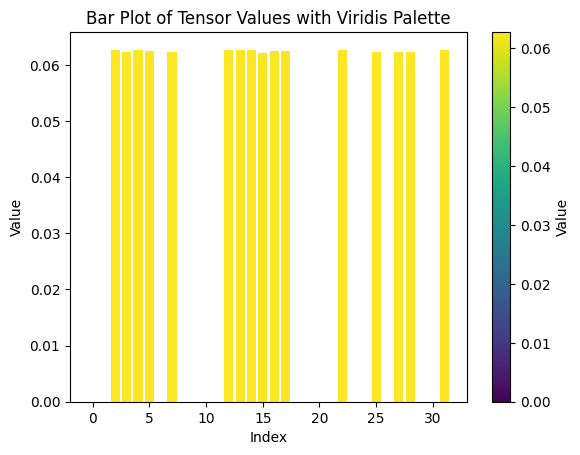

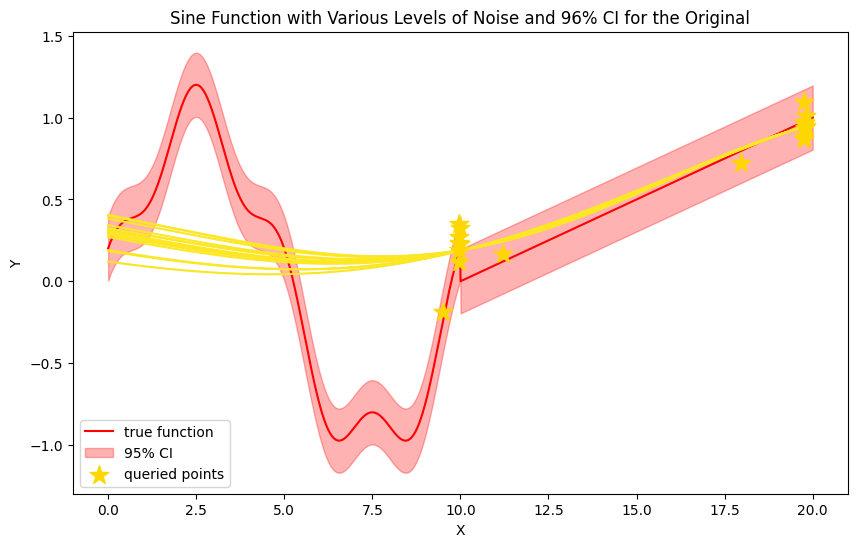

tensor([[0.7071]], dtype=torch.float64)
dict params
{'noise': tensor([0.0934], dtype=torch.float64), 'lengthscale': tensor([[0.3865]], dtype=torch.float64), 'outputscale': tensor([1.3922], dtype=torch.float64), 'mean': tensor([0.0814], dtype=torch.float64)}
32
{'noise': tensor([0.8890, 0.4595, 0.1899, 1.6902, 0.3347, 0.7697, 0.3261, 0.3359, 4.5497,
        0.2685, 0.6046, 2.3470, 0.3377, 0.1191, 0.4764, 1.3593, 1.9956, 1.9905,
        0.5936, 2.7955, 0.1881, 0.7760, 0.1870, 1.5334, 0.6753, 0.1040, 2.0510,
        1.8221, 0.7310, 1.0991, 0.2386, 0.0934], dtype=torch.float64), 'outputscale': tensor([ 3.1142,  1.3962, 20.2038,  0.0977,  0.4568,  0.3575,  1.0573,  0.3852,
         0.9705,  2.6422,  2.8914,  0.3936,  0.4318,  0.8150,  2.1048,  1.1040,
         0.7945,  2.6407,  0.5385, 13.2844,  0.4700,  5.9964,  6.7541,  1.3626,
         1.6880,  1.1553,  1.0993,  0.9076,  0.9781,  0.3809,  2.3117,  1.3922],
       dtype=torch.float64), 'mean': tensor([-0.1754, -0.0589,  0.6546,  0.6977,  

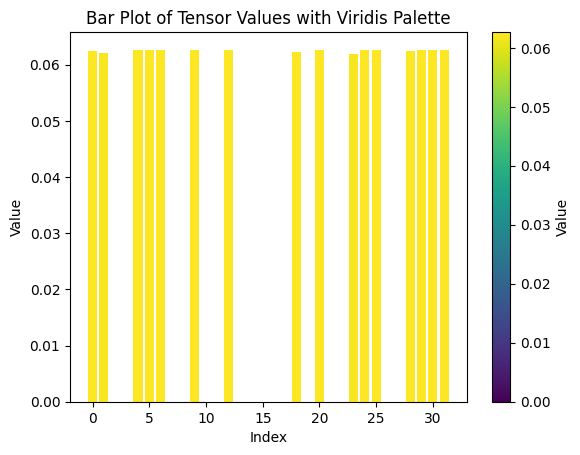

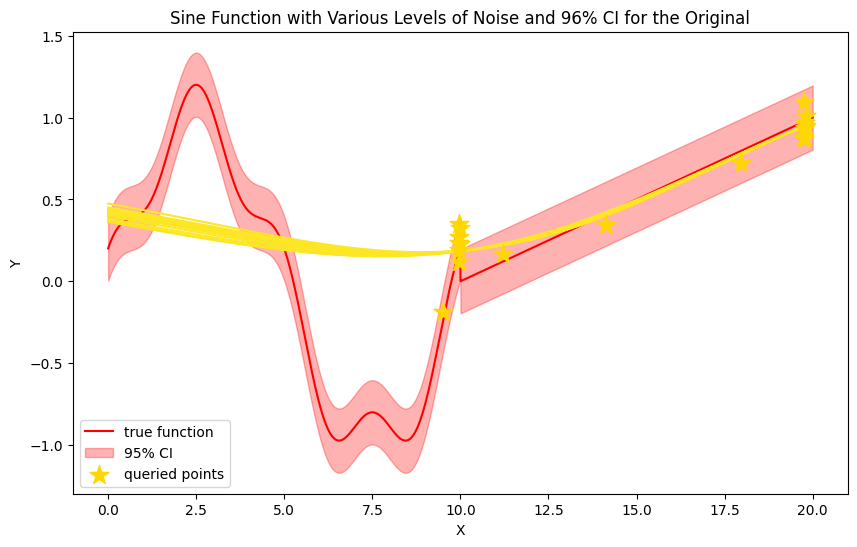

tensor([[0.9886]], dtype=torch.float64)
dict params
{'noise': tensor([0.0948], dtype=torch.float64), 'lengthscale': tensor([[0.3600]], dtype=torch.float64), 'outputscale': tensor([1.3696], dtype=torch.float64), 'mean': tensor([0.2123], dtype=torch.float64)}
32
{'noise': tensor([0.1485, 1.4989, 2.5753, 0.6330, 0.5715, 6.2484, 0.5858, 2.4498, 0.2958,
        0.3792, 0.1509, 1.6855, 5.8312, 0.2162, 0.1816, 2.4313, 2.6214, 0.2172,
        1.6120, 0.4317, 1.0617, 0.4159, 5.0939, 1.1157, 1.2633, 0.4846, 1.0871,
        0.7094, 0.8455, 0.5557, 0.4155, 0.0948], dtype=torch.float64), 'outputscale': tensor([0.5537, 2.3386, 1.1738, 4.5384, 4.1340, 0.5202, 1.4907, 0.3293, 0.6808,
        1.3491, 3.9653, 2.6996, 1.4500, 1.8039, 1.9777, 0.7794, 0.9735, 0.8031,
        1.5292, 1.9540, 3.3453, 0.6095, 1.5064, 0.6557, 2.0063, 0.3849, 3.2832,
        0.3032, 3.7624, 5.8517, 0.8946, 1.3696], dtype=torch.float64), 'mean': tensor([-0.4061, -0.7721, -0.0756,  1.3719,  0.1319,  0.3215, -0.2740, -1.4455,
    

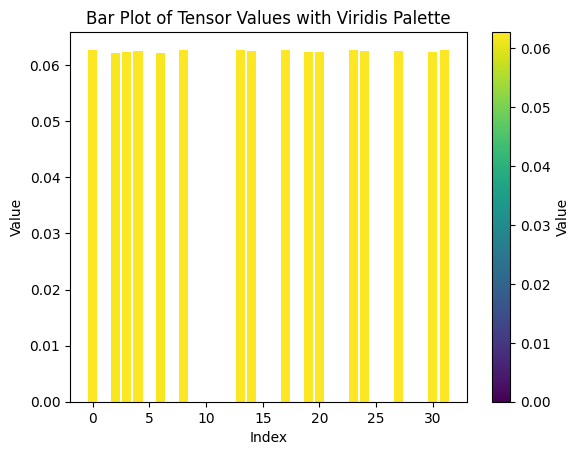

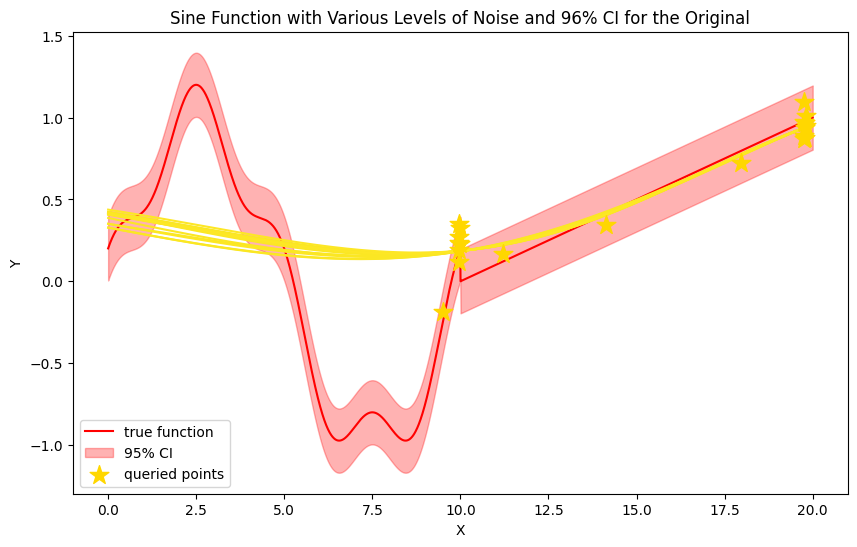

tensor([[0.9999]], dtype=torch.float64)
dict params
{'noise': tensor([0.0928], dtype=torch.float64), 'lengthscale': tensor([[0.3668]], dtype=torch.float64), 'outputscale': tensor([1.3664], dtype=torch.float64), 'mean': tensor([0.1657], dtype=torch.float64)}
32
{'noise': tensor([0.7531, 0.8082, 0.8478, 0.7570, 1.8766, 3.0814, 1.6178, 1.2105, 2.9029,
        0.1693, 1.5855, 1.4974, 0.1709, 0.8155, 0.3211, 0.9622, 5.5551, 1.0406,
        6.2394, 1.8628, 1.7359, 0.6612, 1.2326, 0.6007, 0.8699, 2.1207, 1.5135,
        0.3087, 5.2529, 1.7179, 2.4164, 0.0928], dtype=torch.float64), 'outputscale': tensor([ 2.8927,  4.8222,  0.2881,  2.4529,  0.7808,  0.3298,  0.8071,  8.3772,
         0.6187,  0.7790,  0.5097,  0.1879, 25.8112,  1.2091,  0.9272,  0.7586,
         0.9744,  2.4603,  1.5518,  3.9599, 11.9104,  0.5663,  0.7636,  0.6897,
         6.2831,  1.0464,  1.2847,  1.0186,  0.7470,  1.7291,  0.6404,  1.3664],
       dtype=torch.float64), 'mean': tensor([ 1.3925, -1.5080, -1.2767, -1.6104,  

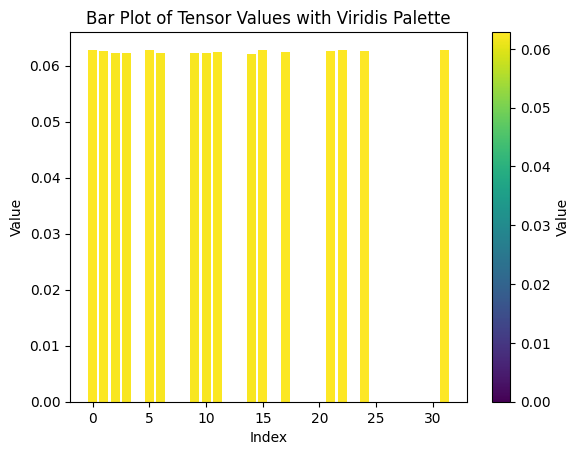

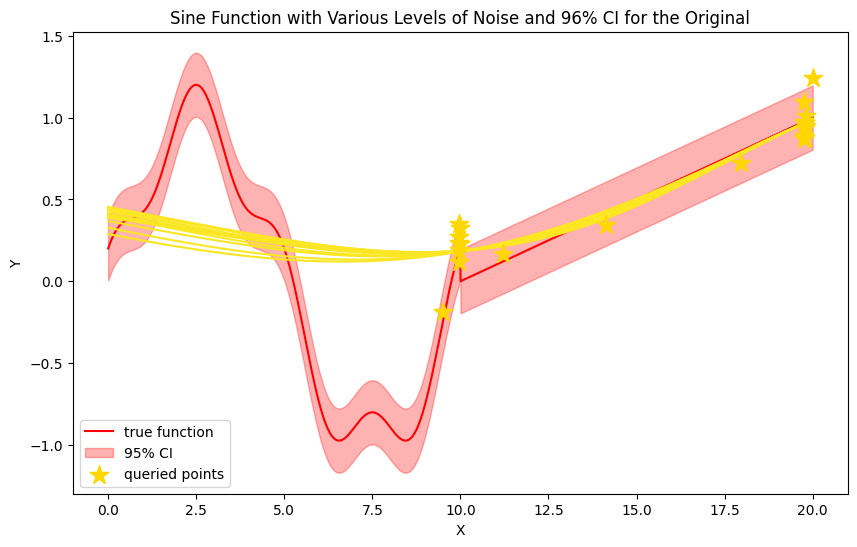

tensor([[0.5090]], dtype=torch.float64)
dict params
{'noise': tensor([0.1031], dtype=torch.float64), 'lengthscale': tensor([[0.3686]], dtype=torch.float64), 'outputscale': tensor([1.4680], dtype=torch.float64), 'mean': tensor([0.1891], dtype=torch.float64)}
32
{'noise': tensor([2.0788, 6.0251, 0.1969, 2.1142, 2.9431, 0.7581, 1.5485, 2.7288, 4.0343,
        1.0854, 0.8121, 0.7518, 2.7657, 3.7425, 0.5665, 0.9081, 2.1874, 2.9223,
        1.1523, 0.4902, 0.9108, 1.1576, 1.3323, 1.6700, 4.1929, 2.1114, 0.9521,
        1.3922, 2.5028, 1.4614, 0.2919, 0.1031], dtype=torch.float64), 'outputscale': tensor([ 1.9890,  0.9139,  0.3535,  4.5365,  2.2026,  0.6719,  1.3787,  1.2427,
         1.8422,  0.3939,  3.3718,  0.7890,  3.2391,  0.3006,  1.6555,  2.2647,
         0.2613,  0.6355,  0.7056, 11.5868,  0.9668,  1.1560,  1.0887,  1.1446,
         1.8692,  0.8771,  0.8058,  0.3826, 10.3640,  0.7655,  0.7528,  1.4680],
       dtype=torch.float64), 'mean': tensor([ 1.2404, -0.1532,  1.4621,  1.2428,  

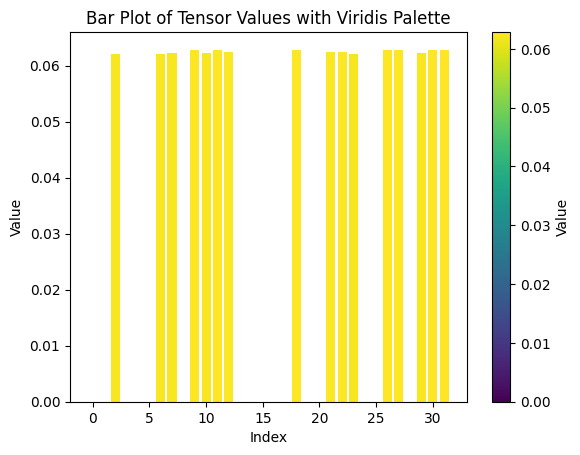

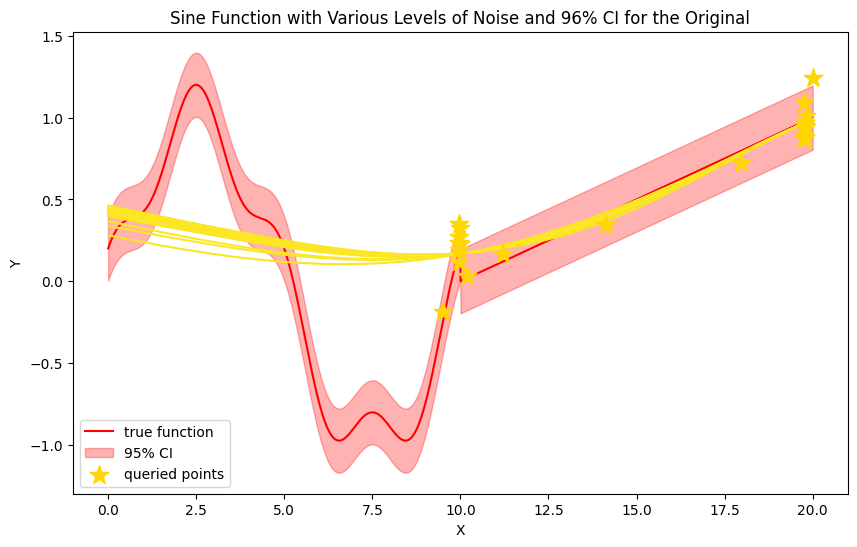

tensor([[0.5094]], dtype=torch.float64)
dict params
{'noise': tensor([0.0999], dtype=torch.float64), 'lengthscale': tensor([[0.3704]], dtype=torch.float64), 'outputscale': tensor([1.4541], dtype=torch.float64), 'mean': tensor([0.2263], dtype=torch.float64)}
32
{'noise': tensor([ 1.7375,  0.9809,  2.2299,  0.8477,  2.2188,  1.6123,  3.0743, 19.0921,
         0.0734,  0.3810,  0.7711,  1.7403,  1.6147,  1.3337,  0.6032,  2.5089,
         1.5972,  0.7564,  1.5502,  1.7327,  3.1535,  1.6888,  0.4846,  2.1564,
         1.8167,  4.6812,  0.3407,  0.2431,  1.4882,  3.5758,  1.2467,  0.0999],
       dtype=torch.float64), 'outputscale': tensor([2.5063, 0.6409, 0.4766, 1.2285, 1.1588, 1.2165, 0.8069, 0.1240, 0.6785,
        1.8213, 1.7781, 0.3434, 3.8236, 0.4062, 1.0544, 0.5674, 0.8231, 0.6771,
        1.4246, 0.3021, 1.5505, 0.7219, 1.2102, 0.2825, 0.4194, 0.9812, 2.3072,
        3.3832, 1.2340, 0.6235, 1.0268, 1.4541], dtype=torch.float64), 'mean': tensor([-2.1717, -0.2284,  0.5194, -0.8064, -

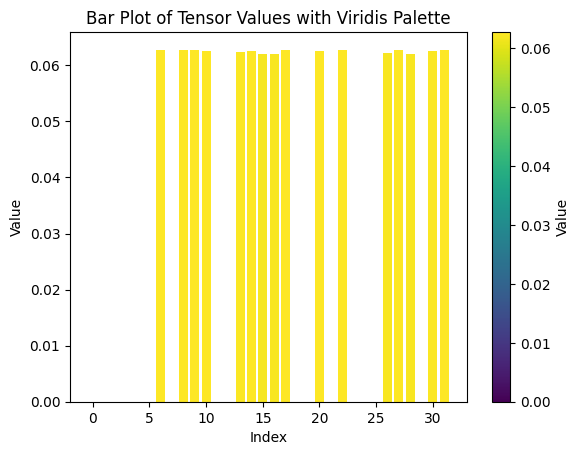

KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
synthetic_function = Higdon(noise_std=0.1).to(**tkwargs)
bounds = BOUNDS
    #print(bounds)
X = SobolEngine(dimension=DIM, scramble=True, seed=0).draw(3).to(**tkwargs)
    #print(X)
X_scaled = convert_bounds(X, BOUNDS, DIM)
Y = synthetic_function(X_scaled).unsqueeze(-1)
poolU = get_candidate_pool(dim=DIM, bounds=BOUNDS, size=10000).to(**tkwargs)
X_test, Y_test = get_test_set(synthetic_function=synthetic_function, 
                                  bounds=bounds, 
                                  dim=DIM, 
                                  noise_std=0.1,
                                  size=10000)  
     
X_test, Y_test = X_test.to(**tkwargs), Y_test.to(**tkwargs)
dict_best_params = None
for i in range(60):
    train_Y = Y  # Flip the sign since we want to minimize f(x)
    gp = MGPFullyBayesianSingleTaskGP(
        train_X=X, 
        train_Y=train_Y, 
        #train_Yvar=torch.full_like(train_Y, 1e-6),
        #input_transform=Normalize(d=cfg.functions.dim, bounds=bountensor_scaledds),
        outcome_transform=Standardize(m=1)
    )
    if type == 'part_bayesian':
        ll = fit_partially_bayesian_mgp_model(model=gp,
                                                num_samples= 32,
                                                lr=0.1,
                                                learning_steps=50,
                                                print_iter=False,
                                                plot=False, 
                                                dict_params=dict_best_params)
        dict_best_params = get_best_model_params(gp, ll=ll)
        print(dict_best_params)
    else:
        ll = fit_fully_bayesian_mgp_model_nuts(gp,
                                            warmup_steps=256,
                                            num_samples=128 ,
                                            thinning=6,
                                            disable_progbar=False)
    acq_function = BALDKLMMAcquisitionFunction(gp, ll=ll)
    if ll is not None:
        ll = ll.detach()
        likelihoods = ll.exp()
        median_val = np.percentile(likelihoods, 50)
        print(median_val)

        likelihoods[likelihoods < median_val] = 0
        weights = likelihoods.pow(1).squeeze().div(likelihoods.pow(1).sum())
        npll = weights.numpy()
        norm = plt.Normalize(npll.min(), npll.max())
        colors = plt.cm.viridis(norm(npll))
    # Generate a sequence of colors from the 'viridis' colormap

    # Plotting
        plt.bar(range(len(npll)), npll, color=colors)
        plt.ylabel('Value')
        plt.xlabel('Index')
        plt.title('Bar Plot of Tensor Values with Viridis Palette')
        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), label='Value')
        plt.show()

    acq_values = acq_function(poolU)
    best_index = torch.argmax(acq_values)
    candidates = poolU[best_index].unsqueeze(-1)
    new_pool = torch.cat((poolU[:best_index], poolU[best_index + 1:]), dim=0)
    candidates, best_acq_value, poolU = candidates.T, acq_values[best_index].unsqueeze(-1), new_pool

    candidates_scaled = convert_bounds(candidates, BOUNDS, DIM)
    y_hat = get_yhat(gp, X_test, tkwargs)
    plot_gps(X_test, 0.1, synthetic_function, y_hat, X, Y, weights)
    Y_next = synthetic_function(candidates_scaled).unsqueeze(-1)
    if DIM ==1:
        Y_next=Y_next.unsqueeze(-1)
    Y = torch.cat((Y, Y_next)).to(**tkwargs)
    X = torch.cat((X, candidates)).to(**tkwargs)
    print(candidates)

In [ ]:
new=2
gp.covar_module.base_kernel.lengthscale[0].fill_(2.0)

tensor([[2.]], dtype=torch.float64, grad_fn=<AsStridedBackward0>)

In [ ]:
torch.Tensor([1]).unsqueeze(-1)

tensor([[1.]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_yhat(gp, test_X, tkwargs, batch_size = 100):

    total_batches = test_X.size(0) // batch_size
    Y_full = torch.Tensor().to(**tkwargs)
    for i in range(total_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_X = test_X[start_idx:end_idx]
        posterior = gp.posterior(batch_X)
        Y_hat = posterior.mean
        Y_full = torch.cat((Y_full, Y_hat),1)
    return Y_full

def plot_gps(test_X, std, synthetic_function, Y_hat, X_train, Y_train, ll = None):

        # Define the sine function
    test_X = convert_bounds(test_X,BOUNDS, DIM)
    x = test_X.detach().squeeze().numpy()
    #y = test_Y.detach().numpy()
    y = synthetic_function.evaluate_true(test_X).numpy()
    X_train = convert_bounds(X_train,BOUNDS, DIM)
    x_points = X_train.detach().squeeze().numpy()
    y_points = Y_train.detach().numpy()

    # Generate noisy versions of y
    gps_y = Y_hat.detach().squeeze().numpy()
    
    ci = 1.96 * std

    df = pd.DataFrame({'x': x, "y": y})
    df['y_lower'] = df.y - ci
    df['y_upper'] = df.y + ci

    gp_cols = []
    for i in range(len(gps_y)):
        gp_col = 'gp_' + str(i)
        df[gp_col] = gps_y[i]
        gp_cols.append(gp_col)
    df = df.sort_values(by='x', ascending=True).reset_index(drop=True)
    
    # Normalize the ll values to 0-1 for color mapping
    if ll is not None:
        ll = ll.exp().detach().squeeze().div(ll.exp().detach().sum())
        #ll = ll.detach().numpy()
        norm = plt.Normalize(min(ll), max(ll))
        cmap = plt.cm.viridis  # Choose a colormap

    plt.figure(figsize=(10, 6))
    plt.plot(df.x, df.y, label='true function', color='red')
    plt.fill_between(df.x, df.y_lower, df.y_upper, color='red', alpha=0.3, label='95% CI')

    for i, gp_col in enumerate(gp_cols):
        color = cmap(norm(ll[i])) if ll is not None else 'blue'  # Use ll value for color if ll is provided
        plt.plot(df.x, df[gp_col], color=color)
    
    plt.scatter(x_points, y_points, color='gold', s=200, marker='*', label='queried points', zorder=30)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Sine Function with Various Levels of Noise and 96% CI for the Original')
    plt.show()
